# CIFAR 10 Image Classification

⚠ **NOTE:** You should make use of GPU acceleration in this notebook. 



# Import Packages

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
import pickle

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load Training DataFrame

In [2]:
#load the data
train = pd.read_csv('../input/cifar10-mu/train.csv', dtype = str)
train.shape

(50000, 2)

In [3]:
#review training data
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  50000 non-null  object
 1   label     50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [4]:
#display the head of the DataFrame. 
train.head()

,filename,label
0,train_00001.png,1
1,train_00002.png,0
2,train_00003.png,2
3,train_00004.png,2
4,train_00005.png,1


# Label Distribution

In [5]:
# Display the proportion of observations with each possible of the target variable
y_train = train.label

(train.label.value_counts() / len(train)).to_frame()

,label
1,0.1
0,0.1
2,0.1
6,0.1
5,0.1
4,0.1
7,0.1
9,0.1
8,0.1
3,0.1


In [6]:
train_path = "../input/cifar10-mu/train_images"
print('Training Images:', len(os.listdir(train_path)))

Training Images: 50000


# View Sample of Images

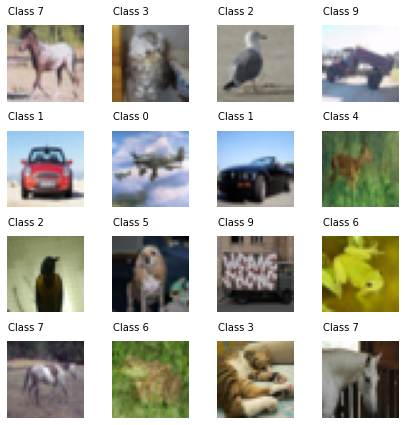

In [7]:
# Sample 16 images, display with their labels in a 4x4 grid, set the figure size to (6,6)

sample = train.sample(n = 16).reset_index()

plt.figure(figsize = (6, 6))

for i, row in sample.iterrows():
    img = mpimg.imread(f'../input/cifar10-mu/train_images/{row.filename}')    
    lab = row.label

    plt.subplot(4, 4, i+1)
    plt.imshow(img)
    plt.text(0, -5, f'Class {lab}')
        
    plt.axis('off')
    
plt.tight_layout()    
plt.show()

# Data Generators

In [8]:
#split the training data
train_df, valid_df = train_test_split(train, test_size = 0.2, random_state = 3, stratify = train.label)

print(train_df.shape)
print(valid_df.shape)

(40000, 2)
(10000, 2)


In [9]:
# Create image data generators
train_datagen = ImageDataGenerator(rescale = 1/255)
valid_datagen = ImageDataGenerator(rescale = 1/255)

In [10]:
BATCH_SIZE = 64

train_loader = train_datagen.flow_from_dataframe(
    dataframe = train_df,
    directory = train_path,
    x_col = 'filename',
    y_col = 'label',
    batch_size = BATCH_SIZE,
    seed = 1,
    shuffle = True,
    class_mode = 'categorical',
    target_size = (32, 32)
)

valid_loader = valid_datagen.flow_from_dataframe(
    dataframe = valid_df,
    directory = train_path,
    x_col = 'filename',
    y_col = 'label',
    batch_size = BATCH_SIZE,
    seed = 1,
    shuffle = True,
    class_mode = 'categorical',
    target_size = (32, 32)
)

Found 40000 validated image filenames belonging to 10 classes.
Found 10000 validated image filenames belonging to 10 classes.


In [11]:
# Determine the number of training and validation batches. 
 
TR_STEPS = len(train_loader)
VA_STEPS = len(valid_loader)

print(TR_STEPS)
print(VA_STEPS)

625
157


# Build Network

In [12]:
np.random.seed(1)
tf.random.set_seed(1)

cnn = Sequential([
    Conv2D(32, (3, 3), activation = 'relu', padding = 'same', input_shape=(32, 32, 3)),
    Conv2D(32, (3, 3), activation = 'relu', padding = 'same'),
    MaxPooling2D(2, 2),
    Dropout(0.5),
    BatchNormalization(),

    Conv2D(64, (3, 3), activation = 'relu', padding = 'same'),
    Conv2D(64, (3, 3), activation = 'relu', padding = 'same'),
    MaxPooling2D(2, 2),
    Dropout(0.25),
    BatchNormalization(),

    Conv2D(128, (3, 3), activation = 'relu', padding = 'same'),
    Conv2D(128, (3, 3), activation = 'relu', padding = 'same'),
    MaxPooling2D(2, 2),
    Dropout(0.5),
    BatchNormalization(),

    Flatten(),
    
    Dense(128, activation='relu'),
    Dropout(0.25),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.25),
    BatchNormalization(),
    Dense(10, activation='softmax')
])

cnn.summary()

2021-10-30 23:23:04.260334: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 16, 16, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)        3

2021-10-30 23:23:04.350697: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-30 23:23:04.351862: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-30 23:23:04.354479: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-10-30 23:23:04.355606: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

# Train Network

In [13]:
opt = tf.keras.optimizers.Adam(0.001)

cnn.compile(loss = 'categorical_crossentropy', optimizer = opt, metrics = ['accuracy', tf.keras.metrics.AUC()])

In [14]:
%%time 

h1 = cnn.fit(x = train_loader,
             steps_per_epoch = TR_STEPS, 
             epochs = 20, 
             validation_data = valid_loader, 
             validation_steps = VA_STEPS, 
             verbose = 1
)

2021-10-30 23:23:28.108616: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20


2021-10-30 23:23:30.600023: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


625/625 [==============================] - 210s 324ms/step - loss: 2.1139 - accuracy: 0.2216 - auc: 0.7067 - val_loss: 2.0354 - val_accuracy: 0.2148 - val_auc: 0.7440
Epoch 2/20
625/625 [==============================] - 38s 61ms/step - loss: 1.6979 - accuracy: 0.3518 - auc: 0.8312 - val_loss: 1.4616 - val_accuracy: 0.4637 - val_auc: 0.8776
Epoch 3/20
625/625 [==============================] - 37s 60ms/step - loss: 1.5040 - accuracy: 0.4444 - auc: 0.8706 - val_loss: 1.4716 - val_accuracy: 0.4832 - val_auc: 0.8819
Epoch 4/20
625/625 [==============================] - 37s 60ms/step - loss: 1.3422 - accuracy: 0.5223 - auc: 0.8980 - val_loss: 1.4746 - val_accuracy: 0.5003 - val_auc: 0.8781
Epoch 5/20
625/625 [==============================] - 37s 59ms/step - loss: 1.2249 - accuracy: 0.5774 - auc: 0.9150 - val_loss: 1.0565 - val_accuracy: 0.6334 - val_auc: 0.9353
Epoch 6/20
625/625 [==============================] - 38s 61ms/step - loss: 1.1448 - accuracy: 0.6083 - auc: 0.9257 - val_loss: 0

In [15]:
history = h1.history

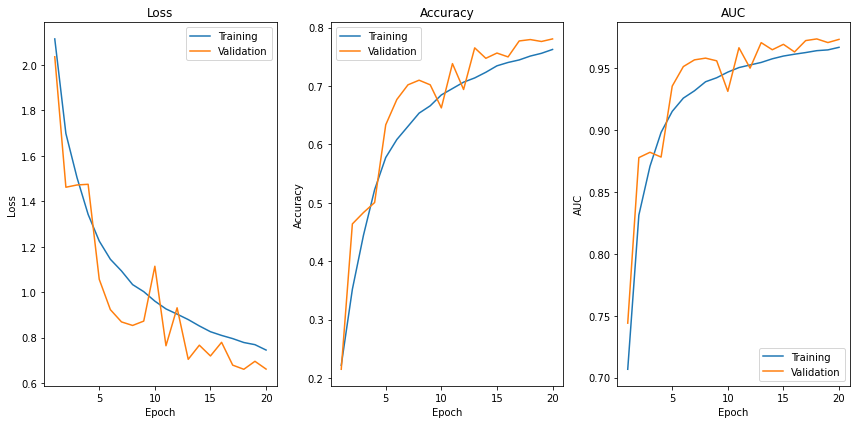

In [16]:
epoch_range = range(1, len(history['loss']) + 1)

plt.figure(figsize=[12,6])
plt.subplot(1, 3, 1)
plt.plot(epoch_range, history['loss'], label='Training')
plt.plot(epoch_range, history['val_loss'], label='Validation')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(epoch_range, history['accuracy'], label='Training')
plt.plot(epoch_range, history['val_accuracy'], label='Validation')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Accuracy')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(epoch_range, history['auc'], label='Training')
plt.plot(epoch_range, history['val_auc'], label='Validation')
plt.xlabel('Epoch'); plt.ylabel('AUC'); plt.title('AUC')
plt.legend()

plt.tight_layout()
plt.show()

In [17]:
#decrease the learning rate 
tf.keras.backend.set_value(cnn.optimizer.learning_rate, 0.0001)

In [18]:
%%time 

h2 = cnn.fit(x = train_loader,
             steps_per_epoch = TR_STEPS, 
             epochs = 15, 
             validation_data = valid_loader, 
             validation_steps = VA_STEPS, 
             verbose = 1
)

Epoch 1/15
625/625 [==============================] - 37s 59ms/step - loss: 0.6883 - accuracy: 0.7828 - auc: 0.9715 - val_loss: 0.5627 - val_accuracy: 0.8112 - val_auc: 0.9806
Epoch 2/15
625/625 [==============================] - 36s 58ms/step - loss: 0.6628 - accuracy: 0.7885 - auc: 0.9734 - val_loss: 0.5710 - val_accuracy: 0.8097 - val_auc: 0.9792
Epoch 3/15
625/625 [==============================] - 37s 60ms/step - loss: 0.6543 - accuracy: 0.7923 - auc: 0.9740 - val_loss: 0.5563 - val_accuracy: 0.8148 - val_auc: 0.9804
Epoch 4/15
625/625 [==============================] - 37s 60ms/step - loss: 0.6499 - accuracy: 0.7946 - auc: 0.9741 - val_loss: 0.5512 - val_accuracy: 0.8163 - val_auc: 0.9806
Epoch 5/15
625/625 [==============================] - 37s 58ms/step - loss: 0.6442 - accuracy: 0.7954 - auc: 0.9745 - val_loss: 0.5510 - val_accuracy: 0.8184 - val_auc: 0.9806
Epoch 6/15
625/625 [==============================] - 36s 58ms/step - loss: 0.6321 - accuracy: 0.8008 - auc: 0.9754 - va

In [19]:
for h in history.keys():
    history[h] += h2.history[h]

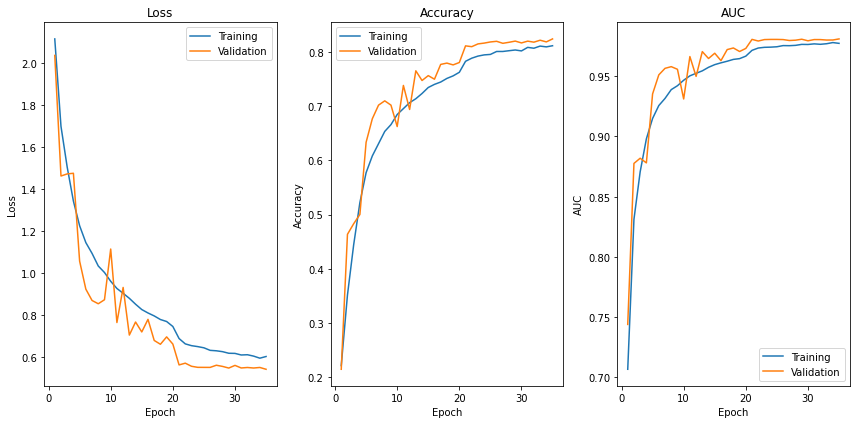

In [20]:
epoch_range = range(1, len(history['loss']) + 1)

plt.figure(figsize=[12,6])
plt.subplot(1, 3, 1)
plt.plot(epoch_range, history['loss'], label='Training')
plt.plot(epoch_range, history['val_loss'], label='Validation')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(epoch_range, history['accuracy'], label='Training')
plt.plot(epoch_range, history['val_accuracy'], label='Validation')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Accuracy')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(epoch_range, history['auc'], label='Training')
plt.plot(epoch_range, history['val_auc'], label='Validation')
plt.xlabel('Epoch'); plt.ylabel('AUC'); plt.title('AUC')
plt.legend()

plt.tight_layout()
plt.show()

# Save Model and History

In [21]:
cnn.save('cifar10_model_v01.h5')
pickle.dump(history, open(f'cifar10_model_v01.pk1', 'wb'))